In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=20,20
import seaborn as sns
from fastaUtils.profiles import parse_profile,profile_data
from sklearn.decomposition import PCA
from umap import UMAP

tfk=tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

## Classes and helper functions

In [3]:
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K
class LRFinder(Callback):
    def __init__(self, min_lr, max_lr, mom=0.9, stop_multiplier=None, 
                 reload_weights=True, batches_lr_update=5):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.mom = mom
        self.reload_weights = reload_weights
        self.batches_lr_update = batches_lr_update
        if stop_multiplier is None:
            self.stop_multiplier = -20*self.mom/3 + 10 # 4 if mom=0.9
                                                       # 10 if mom=0
        else:
            self.stop_multiplier = stop_multiplier
        
    def on_train_begin(self, logs={}):
        p = self.params
        try:
            n_iterations = p['epochs']*p['samples']//p['batch_size']
        except:
            n_iterations = p['steps']*p['epochs']
            
        self.learning_rates = np.geomspace(self.min_lr, self.max_lr, \
                                           num=n_iterations//self.batches_lr_update+1)
        self.losses=[]
        self.iteration=0
        self.best_loss=0
        if self.reload_weights:
            self.model.save_weights('tmp.hdf5')
        
    
    def on_batch_end(self, batch, logs={}):
        loss = logs.get('loss')
        
        if self.iteration!=0: # Make loss smoother using momentum
            loss = self.losses[-1]*self.mom+loss*(1-self.mom)
        
        if self.iteration==0 or loss < self.best_loss: 
                self.best_loss = loss
                
        if self.iteration%self.batches_lr_update==0: # Evaluate each lr over 5 epochs
            
            if self.reload_weights:
                self.model.load_weights('tmp.hdf5')
          
            lr = self.learning_rates[self.iteration//self.batches_lr_update]            
            K.set_value(self.model.optimizer.lr, lr)

            self.losses.append(loss)            

        if loss > self.best_loss*self.stop_multiplier: # Stop criteria
            self.model.stop_training = True
                
        self.iteration += 1
    
    def on_train_end(self, logs=None):
        if self.reload_weights:
                self.model.load_weights('tmp.hdf5')
                
        plt.figure(figsize=(12, 6))
        plt.plot(self.learning_rates[:len(self.losses)], self.losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.show()

In [4]:
class AutoregressiveGenerate(tf.keras.Model):
  def __init__(self, model, name=''):
    super(AutoregressiveGenerate, self).__init__(name=name)
    self.model=tfk.models.clone_model(model)
    self.concat = tfkl.concatenate
    
  def call(self, input_tensor, training=False):
    x = self.model(input_tensor)
    x = tfd.OneHotCategorical(logits=x,dtype=tf.float32).sample()
    x = self.concat([input_tensor,x])
    return x

class AutoregressiveFit(tf.keras.Model):
  def __init__(self, model, name=''):
    super(AutoregressiveFit, self).__init__(name=name)
    self.model=tfk.models.clone_model(model)
    self.log_softmax = tf.nn.log_softmax
    
  def call(self, input_tensor, training=False):
    x = self.model(input_tensor)
    x = self.log_softmax(x)
    return x

def makeModelGenerate( cumwidth, makeCell ):
    In=tfkl.Input((cumwidth[1]))
    ar=AutoregressiveGenerate(makeCell(cumwidth[2]-cumwidth[1],name="col1_cell"),name="col1")(In)
    for idx in range(3,len(cumwidth)):
        ar=AutoregressiveGenerate(makeCell(cumwidth[idx]-cumwidth[idx-1],name="col{}_cell".format(idx-1)),name="col{}".format(idx-1))(ar)
    return tfk.models.Model(In,ar)

def makeModelFit( cumwidth, makeCell ):
    In0=tfkl.Input((cumwidth[-1]))
    
    l0=In0[:,0:cumwidth[1]]
    l0=AutoregressiveFit( makeCell(cumwidth[2]-cumwidth[1],name="col1_cell"), name="col1")(l0)
    for c in range(2,len(cumwidth)-1):
        l=In0[:,0:cumwidth[c]]
        l=AutoregressiveFit( makeCell(cumwidth[c+1]-cumwidth[c],name="col{}_cell".format(c)), name="col{}".format(c))(l)
        l0=tfkl.concatenate([l0,l])
    return tfk.models.Model(In0,l0)

lossFit=lambda y,yt:-tf.reduce_mean(tf.reduce_sum(tf.multiply(y,yt),axis=1))

In [5]:
def decodeSequences(sequences,alphabet):
    q=len(alphabet)
    N=sequences.shape[1]//q
    decoded=[]
    for n in range(N):
        s=sequences[:,n*q:n*q+q]
        idx=np.argmax(s,axis=1)
        chars=[alphabet[i] for i in idx]
        decoded.append(chars)
    decoded=np.array(decoded,dtype='str').T
    sequences=[]
    for dec in decoded:
        sequences.append("".join(dec))
    return sequences

## Dataset and settings

In [6]:
dataset="datasets/jdm_A"
outbasename="jdm_A_2x32relu"

x=np.load("{dataset}.npy".format(dataset=dataset)).astype(float) # dataset
cumwidth=profile_data(parse_profile("{dataset}.profile".format(dataset=dataset))).cumulative

np.random.shuffle(x)
x=x[:10000]
Y=x[:,cumwidth[1]:]

epochs=10000
comparetodata=None
Ngen=10000
bs=1024 # batch size

if comparetodata is not None:
    xc=np.load(comparetodata).astype(float)

alphabet=list("-ACDEFGHIKLMNPQRSTVWY")

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
earlystopping = EarlyStopping(monitor='loss', patience=100, verbose=0, mode='min')
checkpoint=ModelCheckpoint("checkpoints/{}_weights".format(outbasename), monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')
reduce_lr=ReduceLROnPlateau(factor=0.2,patience=20,monitor='loss')
lr_finder = LRFinder(min_lr=1e-6, max_lr=0.3,reload_weights=False)

In [7]:
from tensorflow.keras.regularizers import l2

def makeCell( outsize, name ):
    sequential=tfk.models.Sequential(name=name)
    sequential.add( tfkl.Dense(32,kernel_regularizer=l2(0.001),bias_regularizer=l2(0.001),activation='relu') )
    sequential.add( tfkl.Dense(32,kernel_regularizer=l2(0.001),bias_regularizer=l2(0.001),activation='relu') )
    sequential.add( tfkl.Dense(outsize,kernel_regularizer=l2(0.001),bias_regularizer=l2(0.001),activation='linear') )
    return sequential

## Models

In [8]:
generator=makeModelGenerate(cumwidth,makeCell)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
col1 (AutoregressiveGenerate (None, 20)                1741      
_________________________________________________________________
col2 (AutoregressiveGenerate (None, 26)                1926      
_________________________________________________________________
col3 (AutoregressiveGenerate (None, 44)                2514      
_________________________________________________________________
col4 (AutoregressiveGenerate (None, 63)                3123      
_________________________________________________________________
col5 (AutoregressiveGenerate (None, 72)                3401      
_________________________________________________________________
col6 (AutoregressiveGenerate (None, 92)                4052  

In [9]:
autoencoder=makeModelFit(cumwidth,makeCell)
autoencoder.compile(optimizer='sgd', loss=lossFit)
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 974)]        0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 7)            0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 20)           0           input_2[0][0]                    
__________________________________________________________________________________________________
col1 (AutoregressiveFit)        (None, 13)           1741        tf.__operators__.getitem[0][0]   
____________________________________________________________________________________________

## Optimization of learning rate

Epoch 1/20
10/10 [==============================] - 16s 31ms/step - loss: 167.9609
Epoch 2/20
10/10 [==============================] - 0s 30ms/step - loss: 167.4498
Epoch 3/20
10/10 [==============================] - 0s 30ms/step - loss: 167.4472
Epoch 4/20
10/10 [==============================] - 0s 45ms/step - loss: 167.4529
Epoch 5/20
10/10 [==============================] - 0s 38ms/step - loss: 167.4366
Epoch 6/20
10/10 [==============================] - 0s 40ms/step - loss: 167.4000
Epoch 7/20
10/10 [==============================] - 0s 35ms/step - loss: 167.3503
Epoch 8/20
10/10 [==============================] - 0s 30ms/step - loss: 167.2555
Epoch 9/20
10/10 [==============================] - 0s 31ms/step - loss: 167.0514
Epoch 10/20
10/10 [==============================] - 0s 31ms/step - loss: 166.6900
Epoch 11/20
10/10 [==============================] - 0s 30ms/step - loss: 165.9992
Epoch 12/20
10/10 [==============================] - 0s 30ms/step - loss: 164.7433
Epoch 13/20


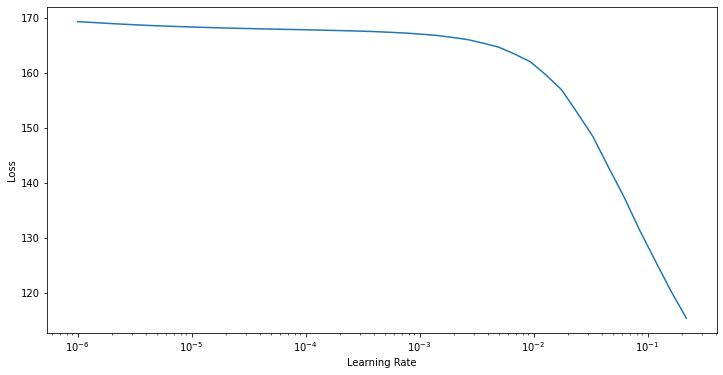

In [10]:
autoencoder.fit(x, Y, callbacks=[lr_finder,checkpoint], epochs=20, shuffle=True, batch_size=bs)

## Fitting

In [11]:
best_lr=1.e-1
optimizer=tf.keras.optimizers.SGD(lr=best_lr)
autoencoder.compile(optimizer=optimizer, loss=lossFit)

try:
    autoencoder.load_weights("checkpoints/{}_weights".format(outbasename))
except:
    print("Cannot load weights")

hist=autoencoder.fit(x,Y,epochs=epochs,shuffle=True,callbacks=[earlystopping,checkpoint,reduce_lr], batch_size=bs)

Epoch 1/10000
10/10 [==============================] - 15s 31ms/step - loss: 70.0904
Epoch 2/10000
10/10 [==============================] - 0s 29ms/step - loss: 66.4802
Epoch 3/10000
10/10 [==============================] - 0s 30ms/step - loss: 64.3047
Epoch 4/10000
10/10 [==============================] - 0s 30ms/step - loss: 62.6156
Epoch 5/10000
10/10 [==============================] - 0s 30ms/step - loss: 60.1083
Epoch 6/10000
10/10 [==============================] - 0s 30ms/step - loss: 59.2239
Epoch 7/10000
10/10 [==============================] - 0s 30ms/step - loss: 57.4169
Epoch 8/10000
10/10 [==============================] - 0s 30ms/step - loss: 56.4785
Epoch 9/10000
10/10 [==============================] - 0s 29ms/step - loss: 55.6186
Epoch 10/10000
10/10 [==============================] - 0s 30ms/step - loss: 54.5579
Epoch 11/10000
10/10 [==============================] - 0s 38ms/step - loss: 53.8536
Epoch 12/10000
10/10 [==============================] - 0s 29ms/step - lo

10/10 [==============================] - 0s 28ms/step - loss: 39.2137
Epoch 98/10000
10/10 [==============================] - 0s 28ms/step - loss: 39.2127
Epoch 99/10000
10/10 [==============================] - 0s 28ms/step - loss: 39.5816
Epoch 100/10000
10/10 [==============================] - 0s 28ms/step - loss: 38.7261
Epoch 101/10000
10/10 [==============================] - 0s 29ms/step - loss: 39.2644
Epoch 102/10000
10/10 [==============================] - 0s 29ms/step - loss: 39.0360
Epoch 103/10000
10/10 [==============================] - 0s 29ms/step - loss: 39.4049
Epoch 104/10000
10/10 [==============================] - 0s 28ms/step - loss: 40.3473
Epoch 105/10000
10/10 [==============================] - 0s 30ms/step - loss: 39.0311
Epoch 106/10000
10/10 [==============================] - 0s 28ms/step - loss: 38.6419
Epoch 107/10000
10/10 [==============================] - 0s 29ms/step - loss: 39.0647
Epoch 108/10000
10/10 [==============================] - 0s 30ms/step - 

10/10 [==============================] - 0s 38ms/step - loss: 35.2415
Epoch 193/10000
10/10 [==============================] - 0s 29ms/step - loss: 35.2178
Epoch 194/10000
10/10 [==============================] - 0s 45ms/step - loss: 35.1601
Epoch 195/10000
10/10 [==============================] - 0s 29ms/step - loss: 35.1076
Epoch 196/10000
10/10 [==============================] - 0s 43ms/step - loss: 35.8162
Epoch 197/10000
10/10 [==============================] - 0s 32ms/step - loss: 35.1591
Epoch 198/10000
10/10 [==============================] - 0s 28ms/step - loss: 35.4387
Epoch 199/10000
10/10 [==============================] - 0s 28ms/step - loss: 35.2418
Epoch 200/10000
10/10 [==============================] - 0s 43ms/step - loss: 35.7011
Epoch 201/10000
10/10 [==============================] - 0s 45ms/step - loss: 35.5860
Epoch 202/10000
10/10 [==============================] - 0s 37ms/step - loss: 34.9318
Epoch 203/10000
10/10 [==============================] - 0s 29ms/step 

10/10 [==============================] - 0s 29ms/step - loss: 33.9136
Epoch 288/10000
10/10 [==============================] - 0s 29ms/step - loss: 33.5876
Epoch 289/10000
10/10 [==============================] - 0s 29ms/step - loss: 33.6883
Epoch 290/10000
10/10 [==============================] - 0s 28ms/step - loss: 34.1030
Epoch 291/10000
10/10 [==============================] - 0s 28ms/step - loss: 34.3432
Epoch 292/10000
10/10 [==============================] - 0s 29ms/step - loss: 34.1033
Epoch 293/10000
10/10 [==============================] - 0s 28ms/step - loss: 36.9853
Epoch 294/10000
10/10 [==============================] - 0s 28ms/step - loss: 34.3914
Epoch 295/10000
10/10 [==============================] - 0s 28ms/step - loss: 33.9381
Epoch 296/10000
10/10 [==============================] - 0s 29ms/step - loss: 34.0284
Epoch 297/10000
10/10 [==============================] - 0s 29ms/step - loss: 33.9596
Epoch 298/10000
10/10 [==============================] - 0s 28ms/step 

10/10 [==============================] - 0s 28ms/step - loss: 30.5786
Epoch 383/10000
10/10 [==============================] - 0s 29ms/step - loss: 30.6010
Epoch 384/10000
10/10 [==============================] - 0s 34ms/step - loss: 30.5427
Epoch 385/10000
10/10 [==============================] - 0s 29ms/step - loss: 30.5977
Epoch 386/10000
10/10 [==============================] - 0s 36ms/step - loss: 30.6485
Epoch 387/10000
10/10 [==============================] - 0s 29ms/step - loss: 30.4518
Epoch 388/10000
10/10 [==============================] - 0s 29ms/step - loss: 30.4543
Epoch 389/10000
10/10 [==============================] - 0s 29ms/step - loss: 30.4350
Epoch 390/10000
10/10 [==============================] - 0s 30ms/step - loss: 30.5248
Epoch 391/10000
10/10 [==============================] - 0s 29ms/step - loss: 30.6549
Epoch 392/10000
10/10 [==============================] - 0s 28ms/step - loss: 30.4695
Epoch 393/10000
10/10 [==============================] - 0s 29ms/step 

10/10 [==============================] - 0s 29ms/step - loss: 29.9140
Epoch 478/10000
10/10 [==============================] - 0s 29ms/step - loss: 29.7668
Epoch 479/10000
10/10 [==============================] - 0s 29ms/step - loss: 29.9761
Epoch 480/10000
10/10 [==============================] - 0s 28ms/step - loss: 29.9436
Epoch 481/10000
10/10 [==============================] - 0s 29ms/step - loss: 29.8953
Epoch 482/10000
10/10 [==============================] - 0s 29ms/step - loss: 29.8863
Epoch 483/10000
10/10 [==============================] - 0s 28ms/step - loss: 29.8776
Epoch 484/10000
10/10 [==============================] - 0s 29ms/step - loss: 29.7507
Epoch 485/10000
10/10 [==============================] - 0s 28ms/step - loss: 29.8776
Epoch 486/10000
10/10 [==============================] - 0s 29ms/step - loss: 29.9062
Epoch 487/10000
10/10 [==============================] - 0s 29ms/step - loss: 29.8375
Epoch 488/10000
10/10 [==============================] - 0s 29ms/step 

10/10 [==============================] - 0s 31ms/step - loss: 29.4106
Epoch 573/10000
10/10 [==============================] - 0s 29ms/step - loss: 29.2642
Epoch 574/10000
10/10 [==============================] - 0s 29ms/step - loss: 29.3754
Epoch 575/10000
10/10 [==============================] - 0s 29ms/step - loss: 29.3743
Epoch 576/10000
10/10 [==============================] - 0s 28ms/step - loss: 29.5109
Epoch 577/10000
10/10 [==============================] - 0s 29ms/step - loss: 29.4278
Epoch 578/10000
10/10 [==============================] - 0s 29ms/step - loss: 29.3038
Epoch 579/10000
10/10 [==============================] - 0s 29ms/step - loss: 29.3567
Epoch 580/10000
10/10 [==============================] - 0s 28ms/step - loss: 29.2915
Epoch 581/10000
10/10 [==============================] - 0s 29ms/step - loss: 29.3209
Epoch 582/10000
10/10 [==============================] - 0s 29ms/step - loss: 29.3411
Epoch 583/10000
10/10 [==============================] - 0s 29ms/step 

10/10 [==============================] - 0s 28ms/step - loss: 29.0877
Epoch 668/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.9247
Epoch 669/10000
10/10 [==============================] - 0s 28ms/step - loss: 28.9983
Epoch 670/10000
10/10 [==============================] - 0s 31ms/step - loss: 28.9900
Epoch 671/10000
10/10 [==============================] - 0s 30ms/step - loss: 29.0118
Epoch 672/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.7722
Epoch 673/10000
10/10 [==============================] - 0s 30ms/step - loss: 29.0273
Epoch 674/10000
10/10 [==============================] - 0s 29ms/step - loss: 29.0311
Epoch 675/10000
10/10 [==============================] - 0s 29ms/step - loss: 29.0258
Epoch 676/10000
10/10 [==============================] - 0s 29ms/step - loss: 29.0156
Epoch 677/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.9374
Epoch 678/10000
10/10 [==============================] - 0s 29ms/step 

10/10 [==============================] - 0s 29ms/step - loss: 28.6754
Epoch 763/10000
10/10 [==============================] - 0s 37ms/step - loss: 28.5179
Epoch 764/10000
10/10 [==============================] - 0s 48ms/step - loss: 28.6035
Epoch 765/10000
10/10 [==============================] - 0s 32ms/step - loss: 28.6420
Epoch 766/10000
10/10 [==============================] - 0s 28ms/step - loss: 28.7557
Epoch 767/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.7260
Epoch 768/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.8715
Epoch 769/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.5821
Epoch 770/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.7599
Epoch 771/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.5412
Epoch 772/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.5774
Epoch 773/10000
10/10 [==============================] - 0s 29ms/step 

10/10 [==============================] - 0s 28ms/step - loss: 28.4202
Epoch 858/10000
10/10 [==============================] - 0s 30ms/step - loss: 28.5961
Epoch 859/10000
10/10 [==============================] - 0s 31ms/step - loss: 28.5023
Epoch 860/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.4449
Epoch 861/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.5012
Epoch 862/10000
10/10 [==============================] - 0s 28ms/step - loss: 28.5014
Epoch 863/10000
10/10 [==============================] - 0s 31ms/step - loss: 28.5076
Epoch 864/10000
10/10 [==============================] - 0s 31ms/step - loss: 28.4737
Epoch 865/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.3530
Epoch 866/10000
10/10 [==============================] - 0s 28ms/step - loss: 28.3124
Epoch 867/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.4594
Epoch 868/10000
10/10 [==============================] - 0s 29ms/step 

10/10 [==============================] - 0s 29ms/step - loss: 28.2852
Epoch 953/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.1957
Epoch 954/10000
10/10 [==============================] - 0s 28ms/step - loss: 28.1024
Epoch 955/10000
10/10 [==============================] - 0s 28ms/step - loss: 28.3337
Epoch 956/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.1807
Epoch 957/10000
10/10 [==============================] - 0s 28ms/step - loss: 28.1911
Epoch 958/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.1832
Epoch 959/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.9769
Epoch 960/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.1284
Epoch 961/10000
10/10 [==============================] - 0s 28ms/step - loss: 28.1324
Epoch 962/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.1271
Epoch 963/10000
10/10 [==============================] - 0s 29ms/step 

10/10 [==============================] - 0s 43ms/step - loss: 28.0628
Epoch 1047/10000
10/10 [==============================] - 0s 47ms/step - loss: 28.0857
Epoch 1048/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.0646
Epoch 1049/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.1244
Epoch 1050/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.0614
Epoch 1051/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.1789
Epoch 1052/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.0455
Epoch 1053/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.9630
Epoch 1054/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.1240
Epoch 1055/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.2364
Epoch 1056/10000
10/10 [==============================] - 0s 28ms/step - loss: 28.2279
Epoch 1057/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 28.1196
Epoch 1141/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.9848
Epoch 1142/10000
10/10 [==============================] - 0s 28ms/step - loss: 28.1417
Epoch 1143/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.1431
Epoch 1144/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.0025
Epoch 1145/10000
10/10 [==============================] - 0s 28ms/step - loss: 28.0596
Epoch 1146/10000
10/10 [==============================] - 0s 28ms/step - loss: 28.0067
Epoch 1147/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.1574
Epoch 1148/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.1236
Epoch 1149/10000
10/10 [==============================] - 0s 28ms/step - loss: 28.0441
Epoch 1150/10000
10/10 [==============================] - 0s 28ms/step - loss: 28.1091
Epoch 1151/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 28.0376
Epoch 1235/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.0863
Epoch 1236/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.1462
Epoch 1237/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.0868
Epoch 1238/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.0042
Epoch 1239/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.9244
Epoch 1240/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.9928
Epoch 1241/10000
10/10 [==============================] - 0s 28ms/step - loss: 28.1005
Epoch 1242/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.9997
Epoch 1243/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.9850
Epoch 1244/10000
10/10 [==============================] - 0s 28ms/step - loss: 28.0116
Epoch 1245/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 27.9475
Epoch 1329/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.9386
Epoch 1330/10000
10/10 [==============================] - 0s 30ms/step - loss: 28.0033
Epoch 1331/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.9172
Epoch 1332/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.0261
Epoch 1333/10000
10/10 [==============================] - 0s 30ms/step - loss: 28.0937
Epoch 1334/10000
10/10 [==============================] - 0s 32ms/step - loss: 27.9996
Epoch 1335/10000
10/10 [==============================] - 0s 30ms/step - loss: 28.0707
Epoch 1336/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.0424
Epoch 1337/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.0389
Epoch 1338/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.9286
Epoch 1339/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 28.0098
Epoch 1423/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.9505
Epoch 1424/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.8263
Epoch 1425/10000
10/10 [==============================] - 0s 31ms/step - loss: 27.9757
Epoch 1426/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.0887
Epoch 1427/10000
10/10 [==============================] - 0s 29ms/step - loss: 28.0430
Epoch 1428/10000
10/10 [==============================] - 0s 31ms/step - loss: 27.9720
Epoch 1429/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.9459
Epoch 1430/10000
10/10 [==============================] - 0s 30ms/step - loss: 28.0410
Epoch 1431/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.8871
Epoch 1432/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.7814
Epoch 1433/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 30ms/step - loss: 27.8691
Epoch 1517/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.8979
Epoch 1518/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.9018
Epoch 1519/10000
10/10 [==============================] - 0s 30ms/step - loss: 27.9221
Epoch 1520/10000
10/10 [==============================] - 0s 30ms/step - loss: 27.8668
Epoch 1521/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.9186
Epoch 1522/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.8791
Epoch 1523/10000
10/10 [==============================] - 0s 30ms/step - loss: 28.0828
Epoch 1524/10000
10/10 [==============================] - 0s 30ms/step - loss: 27.8333
Epoch 1525/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.9394
Epoch 1526/10000
10/10 [==============================] - 0s 30ms/step - loss: 27.8516
Epoch 1527/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 27.8723
Epoch 1611/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.8937
Epoch 1612/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.7918
Epoch 1613/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.7915
Epoch 1614/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.8331
Epoch 1615/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.9296
Epoch 1616/10000
10/10 [==============================] - 0s 30ms/step - loss: 27.7879
Epoch 1617/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.7678
Epoch 1618/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.9382
Epoch 1619/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.8759
Epoch 1620/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.9100
Epoch 1621/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 27.7854
Epoch 1705/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.8064
Epoch 1706/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.7855
Epoch 1707/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.8475
Epoch 1708/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.7549
Epoch 1709/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.8812
Epoch 1710/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.7547
Epoch 1711/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.7138
Epoch 1712/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.8959
Epoch 1713/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.9404
Epoch 1714/10000
10/10 [==============================] - 0s 30ms/step - loss: 27.8293
Epoch 1715/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 27.7978
Epoch 1799/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.9144
Epoch 1800/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.8883
Epoch 1801/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.7097
Epoch 1802/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.6862
Epoch 1803/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.8718
Epoch 1804/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.8094
Epoch 1805/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.7143
Epoch 1806/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.7296
Epoch 1807/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.7719
Epoch 1808/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.7278
Epoch 1809/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 28ms/step - loss: 27.7152
Epoch 1893/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.6840
Epoch 1894/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.5772
Epoch 1895/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.7735
Epoch 1896/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.7553
Epoch 1897/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.8435
Epoch 1898/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.6403
Epoch 1899/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.6821
Epoch 1900/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.6730
Epoch 1901/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.7874
Epoch 1902/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.7682
Epoch 1903/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 27.6584
Epoch 1987/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.7086
Epoch 1988/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.7792
Epoch 1989/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.7166
Epoch 1990/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.7170
Epoch 1991/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.7883
Epoch 1992/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.7677
Epoch 1993/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.6814
Epoch 1994/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.7163
Epoch 1995/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.6780
Epoch 1996/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.7131
Epoch 1997/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 27.6752
Epoch 2081/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.6585
Epoch 2082/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.7379
Epoch 2083/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.6583
Epoch 2084/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.5924
Epoch 2085/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.6757
Epoch 2086/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.7163
Epoch 2087/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.6978
Epoch 2088/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.5884
Epoch 2089/10000
10/10 [==============================] - 0s 30ms/step - loss: 27.5849
Epoch 2090/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.6428
Epoch 2091/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 27.6611
Epoch 2175/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.6844
Epoch 2176/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.6670
Epoch 2177/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.6080
Epoch 2178/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.6510
Epoch 2179/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.6595
Epoch 2180/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.6600
Epoch 2181/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.5979
Epoch 2182/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.6224
Epoch 2183/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.6917
Epoch 2184/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.6734
Epoch 2185/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 28ms/step - loss: 27.5297
Epoch 2269/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.6775
Epoch 2270/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.4932
Epoch 2271/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.6235
Epoch 2272/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.5797
Epoch 2273/10000
10/10 [==============================] - 0s 30ms/step - loss: 27.6902
Epoch 2274/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.5634
Epoch 2275/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.6546
Epoch 2276/10000
10/10 [==============================] - 0s 30ms/step - loss: 27.6406
Epoch 2277/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.6418
Epoch 2278/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.6946
Epoch 2279/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 27.6161
Epoch 2363/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.5835
Epoch 2364/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.5607
Epoch 2365/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.5223
Epoch 2366/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.6002
Epoch 2367/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.4954
Epoch 2368/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.4485
Epoch 2369/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.6752
Epoch 2370/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.5158
Epoch 2371/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.5445
Epoch 2372/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.4364
Epoch 2373/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 28ms/step - loss: 27.6353
Epoch 2457/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.4914
Epoch 2458/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.4732
Epoch 2459/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.5366
Epoch 2460/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.5393
Epoch 2461/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.5455
Epoch 2462/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.6218
Epoch 2463/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.5317
Epoch 2464/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.5500
Epoch 2465/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.5878
Epoch 2466/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.6300
Epoch 2467/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 33ms/step - loss: 27.4788
Epoch 2551/10000
10/10 [==============================] - 0s 38ms/step - loss: 27.3568
Epoch 2552/10000
10/10 [==============================] - 0s 45ms/step - loss: 27.4987
Epoch 2553/10000
10/10 [==============================] - 0s 46ms/step - loss: 27.5726
Epoch 2554/10000
10/10 [==============================] - 0s 30ms/step - loss: 27.4537
Epoch 2555/10000
10/10 [==============================] - 0s 39ms/step - loss: 27.4670
Epoch 2556/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.5405
Epoch 2557/10000
10/10 [==============================] - 0s 31ms/step - loss: 27.4936
Epoch 2558/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.5290
Epoch 2559/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.4491
Epoch 2560/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.5497
Epoch 2561/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 27.4424
Epoch 2645/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.4073
Epoch 2646/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3931
Epoch 2647/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.2933
Epoch 2648/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.5257
Epoch 2649/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.4015
Epoch 2650/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.4402
Epoch 2651/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.4325
Epoch 2652/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.3435
Epoch 2653/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.5424
Epoch 2654/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.5761
Epoch 2655/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 27.4843
Epoch 2739/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.4384
Epoch 2740/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.4051
Epoch 2741/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.4098
Epoch 2742/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.4672
Epoch 2743/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.5048
Epoch 2744/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.4536
Epoch 2745/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.4687
Epoch 2746/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3864
Epoch 2747/10000
10/10 [==============================] - 0s 30ms/step - loss: 27.5163
Epoch 2748/10000
10/10 [==============================] - 0s 30ms/step - loss: 27.3866
Epoch 2749/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 27.4757
Epoch 2833/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.4554
Epoch 2834/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.4406
Epoch 2835/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.5036
Epoch 2836/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.4175
Epoch 2837/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.4987
Epoch 2838/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.4174
Epoch 2839/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.3907
Epoch 2840/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.4581
Epoch 2841/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3850
Epoch 2842/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3833
Epoch 2843/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 27.4112
Epoch 2927/10000
10/10 [==============================] - 0s 30ms/step - loss: 27.4355
Epoch 2928/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.4143
Epoch 2929/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.4074
Epoch 2930/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.4039
Epoch 2931/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.3559
Epoch 2932/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.4172
Epoch 2933/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.4208
Epoch 2934/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.3741
Epoch 2935/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.4922
Epoch 2936/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.3552
Epoch 2937/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 30ms/step - loss: 27.3020
Epoch 3021/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.4829
Epoch 3022/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.3896
Epoch 3023/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3829
Epoch 3024/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.4270
Epoch 3025/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3859
Epoch 3026/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3587
Epoch 3027/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.4215
Epoch 3028/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3110
Epoch 3029/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3359
Epoch 3030/10000
10/10 [==============================] - 0s 32ms/step - loss: 27.3385
Epoch 3031/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 27.4526
Epoch 3115/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3409
Epoch 3116/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.4788
Epoch 3117/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2909
Epoch 3118/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3863
Epoch 3119/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.4293
Epoch 3120/10000
10/10 [==============================] - 0s 32ms/step - loss: 27.2738
Epoch 3121/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2980
Epoch 3122/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2593
Epoch 3123/10000
10/10 [==============================] - 0s 30ms/step - loss: 27.4349
Epoch 3124/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.4453
Epoch 3125/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 27.3142
Epoch 3209/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.3100
Epoch 3210/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3762
Epoch 3211/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3958
Epoch 3212/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.3795
Epoch 3213/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.3890
Epoch 3214/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2632
Epoch 3215/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3402
Epoch 3216/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3711
Epoch 3217/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3942
Epoch 3218/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3442
Epoch 3219/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 28ms/step - loss: 27.2546
Epoch 3303/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3662
Epoch 3304/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3644
Epoch 3305/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2728
Epoch 3306/10000
10/10 [==============================] - 0s 30ms/step - loss: 27.3406
Epoch 3307/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3606
Epoch 3308/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.3218
Epoch 3309/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.2349
Epoch 3310/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3621
Epoch 3311/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2865
Epoch 3312/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3523
Epoch 3313/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 27.3060
Epoch 3397/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3401
Epoch 3398/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.1904
Epoch 3399/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.2339
Epoch 3400/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2219
Epoch 3401/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.2060
Epoch 3402/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.2442
Epoch 3403/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3747
Epoch 3404/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3309
Epoch 3405/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3614
Epoch 3406/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3133
Epoch 3407/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 27.2025
Epoch 3491/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3219
Epoch 3492/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3032
Epoch 3493/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2557
Epoch 3494/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2669
Epoch 3495/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2597
Epoch 3496/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.1966
Epoch 3497/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.2211
Epoch 3498/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.1859
Epoch 3499/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.3244
Epoch 3500/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2782
Epoch 3501/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 28ms/step - loss: 27.1818
Epoch 3585/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2266
Epoch 3586/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.1940
Epoch 3587/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.2611
Epoch 3588/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.2649
Epoch 3589/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2154
Epoch 3590/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.1877
Epoch 3591/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.2444
Epoch 3592/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2123
Epoch 3593/10000
10/10 [==============================] - 0s 31ms/step - loss: 27.2390
Epoch 3594/10000
10/10 [==============================] - 0s 30ms/step - loss: 27.2654
Epoch 3595/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 28ms/step - loss: 27.1928
Epoch 3679/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2179
Epoch 3680/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.2500
Epoch 3681/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.1969
Epoch 3682/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2194
Epoch 3683/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.2862
Epoch 3684/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.2939
Epoch 3685/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.1588
Epoch 3686/10000
10/10 [==============================] - 0s 31ms/step - loss: 27.2378
Epoch 3687/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2820
Epoch 3688/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.2751
Epoch 3689/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 28ms/step - loss: 27.2006
Epoch 3773/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2247
Epoch 3774/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2118
Epoch 3775/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.2137
Epoch 3776/10000
10/10 [==============================] - 0s 31ms/step - loss: 27.2825
Epoch 3777/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0725
Epoch 3778/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.1936
Epoch 3779/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2220
Epoch 3780/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.1856
Epoch 3781/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0440
Epoch 3782/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2417
Epoch 3783/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 27.1263
Epoch 3867/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.1819
Epoch 3868/10000
10/10 [==============================] - 0s 33ms/step - loss: 27.2516
Epoch 3869/10000
10/10 [==============================] - 0s 30ms/step - loss: 27.1847
Epoch 3870/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.1067
Epoch 3871/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.3285
Epoch 3872/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.1762
Epoch 3873/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.1283
Epoch 3874/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.1073
Epoch 3875/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.1917
Epoch 3876/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2544
Epoch 3877/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 28ms/step - loss: 27.1940
Epoch 3961/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2617
Epoch 3962/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9498
Epoch 3963/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.1862
Epoch 3964/10000
10/10 [==============================] - 0s 35ms/step - loss: 27.1615
Epoch 3965/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.1281
Epoch 3966/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.1503
Epoch 3967/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.1997
Epoch 3968/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.1657
Epoch 3969/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.1985
Epoch 3970/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2630
Epoch 3971/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 28ms/step - loss: 27.1440
Epoch 4055/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2629
Epoch 4056/10000
10/10 [==============================] - 0s 33ms/step - loss: 27.2121
Epoch 4057/10000
10/10 [==============================] - 0s 31ms/step - loss: 27.1547
Epoch 4058/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0727
Epoch 4059/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.1773
Epoch 4060/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.1226
Epoch 4061/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0600
Epoch 4062/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0605
Epoch 4063/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.2253
Epoch 4064/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.1514
Epoch 4065/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 28ms/step - loss: 27.2126
Epoch 4149/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0911
Epoch 4150/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.1832
Epoch 4151/10000
10/10 [==============================] - 0s 35ms/step - loss: 27.0835
Epoch 4152/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.1430
Epoch 4153/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0483
Epoch 4154/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0504
Epoch 4155/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0786
Epoch 4156/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.2130
Epoch 4157/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0969
Epoch 4158/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.1115
Epoch 4159/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 28ms/step - loss: 27.1962
Epoch 4243/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0618
Epoch 4244/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0279
Epoch 4245/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.1770
Epoch 4246/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0829
Epoch 4247/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0347
Epoch 4248/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.1733
Epoch 4249/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0852
Epoch 4250/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.1274
Epoch 4251/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.1936
Epoch 4252/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.1385
Epoch 4253/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 27.1462
Epoch 4337/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.1371
Epoch 4338/10000
10/10 [==============================] - 0s 31ms/step - loss: 27.1355
Epoch 4339/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.9653
Epoch 4340/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0320
Epoch 4341/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0969
Epoch 4342/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.1738
Epoch 4343/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.2287
Epoch 4344/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0925
Epoch 4345/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0720
Epoch 4346/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0988
Epoch 4347/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 27.0114
Epoch 4431/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9433
Epoch 4432/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9997
Epoch 4433/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0344
Epoch 4434/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0315
Epoch 4435/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0794
Epoch 4436/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0089
Epoch 4437/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0288
Epoch 4438/10000
10/10 [==============================] - 0s 35ms/step - loss: 26.9615
Epoch 4439/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0704
Epoch 4440/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0882
Epoch 4441/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 28ms/step - loss: 27.0832
Epoch 4525/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0334
Epoch 4526/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9763
Epoch 4527/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.1116
Epoch 4528/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0418
Epoch 4529/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0047
Epoch 4530/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0673
Epoch 4531/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0381
Epoch 4532/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0174
Epoch 4533/10000
10/10 [==============================] - 0s 34ms/step - loss: 27.0625
Epoch 4534/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0228
Epoch 4535/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 30ms/step - loss: 27.0501
Epoch 4619/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.9961
Epoch 4620/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.9785
Epoch 4621/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.1837
Epoch 4622/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.9807
Epoch 4623/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0348
Epoch 4624/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0752
Epoch 4625/10000
10/10 [==============================] - 0s 33ms/step - loss: 27.0449
Epoch 4626/10000
10/10 [==============================] - 0s 30ms/step - loss: 27.0916
Epoch 4627/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.9827
Epoch 4628/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.1040
Epoch 4629/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 28ms/step - loss: 27.0926
Epoch 4713/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9808
Epoch 4714/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0652
Epoch 4715/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0399
Epoch 4716/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9738
Epoch 4717/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0032
Epoch 4718/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0690
Epoch 4719/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9771
Epoch 4720/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9923
Epoch 4721/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0197
Epoch 4722/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9950
Epoch 4723/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 28ms/step - loss: 26.9424
Epoch 4807/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9860
Epoch 4808/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0272
Epoch 4809/10000
10/10 [==============================] - 0s 32ms/step - loss: 26.9987
Epoch 4810/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.1235
Epoch 4811/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0100
Epoch 4812/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.9653
Epoch 4813/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.9673
Epoch 4814/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.9628
Epoch 4815/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8615
Epoch 4816/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0330
Epoch 4817/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 27.0379
Epoch 4901/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.9560
Epoch 4902/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9415
Epoch 4903/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.9974
Epoch 4904/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.9832
Epoch 4905/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9719
Epoch 4906/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0404
Epoch 4907/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0214
Epoch 4908/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0511
Epoch 4909/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.9174
Epoch 4910/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0230
Epoch 4911/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.9627
Epoch 4995/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0072
Epoch 4996/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.9731
Epoch 4997/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9218
Epoch 4998/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9906
Epoch 4999/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9229
Epoch 5000/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0333
Epoch 5001/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9046
Epoch 5002/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.8653
Epoch 5003/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0729
Epoch 5004/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9763
Epoch 5005/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.9402
Epoch 5089/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.9734
Epoch 5090/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9730
Epoch 5091/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.9765
Epoch 5092/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9496
Epoch 5093/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.9130
Epoch 5094/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8174
Epoch 5095/10000
10/10 [==============================] - 0s 31ms/step - loss: 27.0518
Epoch 5096/10000
10/10 [==============================] - 0s 31ms/step - loss: 27.0137
Epoch 5097/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.9516
Epoch 5098/10000
10/10 [==============================] - 0s 28ms/step - loss: 27.0255
Epoch 5099/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 28ms/step - loss: 26.8534
Epoch 5183/10000
10/10 [==============================] - 0s 30ms/step - loss: 27.0793
Epoch 5184/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.9869
Epoch 5185/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.8783
Epoch 5186/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.8787
Epoch 5187/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9139
Epoch 5188/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8821
Epoch 5189/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9674
Epoch 5190/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9091
Epoch 5191/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.8716
Epoch 5192/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.8534
Epoch 5193/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.9684
Epoch 5277/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9346
Epoch 5278/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.8423
Epoch 5279/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.9390
Epoch 5280/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9493
Epoch 5281/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8936
Epoch 5282/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9211
Epoch 5283/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.9735
Epoch 5284/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9079
Epoch 5285/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8222
Epoch 5286/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9844
Epoch 5287/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.8843
Epoch 5371/10000
10/10 [==============================] - 0s 31ms/step - loss: 27.0076
Epoch 5372/10000
10/10 [==============================] - 0s 32ms/step - loss: 26.8850
Epoch 5373/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8866
Epoch 5374/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.8442
Epoch 5375/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.8634
Epoch 5376/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.9741
Epoch 5377/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8439
Epoch 5378/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7980
Epoch 5379/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9342
Epoch 5380/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9771
Epoch 5381/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.9515
Epoch 5465/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8647
Epoch 5466/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.8735
Epoch 5467/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.8673
Epoch 5468/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.8991
Epoch 5469/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9138
Epoch 5470/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9278
Epoch 5471/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.8367
Epoch 5472/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.8488
Epoch 5473/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8504
Epoch 5474/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8524
Epoch 5475/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 28ms/step - loss: 26.8231
Epoch 5559/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.7960
Epoch 5560/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.8985
Epoch 5561/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8383
Epoch 5562/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9524
Epoch 5563/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.8758
Epoch 5564/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.8773
Epoch 5565/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.8051
Epoch 5566/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.9240
Epoch 5567/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.9708
Epoch 5568/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8796
Epoch 5569/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.8969
Epoch 5653/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8905
Epoch 5654/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8093
Epoch 5655/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8375
Epoch 5656/10000
10/10 [==============================] - 0s 31ms/step - loss: 26.7928
Epoch 5657/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8879
Epoch 5658/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7672
Epoch 5659/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9269
Epoch 5660/10000
10/10 [==============================] - 0s 36ms/step - loss: 26.8267
Epoch 5661/10000
10/10 [==============================] - 0s 29ms/step - loss: 27.0081
Epoch 5662/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.8368
Epoch 5663/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 28ms/step - loss: 26.7713
Epoch 5747/10000
10/10 [==============================] - 0s 31ms/step - loss: 26.7629
Epoch 5748/10000
10/10 [==============================] - 0s 31ms/step - loss: 26.8799
Epoch 5749/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8460
Epoch 5750/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.8574
Epoch 5751/10000
10/10 [==============================] - 0s 33ms/step - loss: 26.8530
Epoch 5752/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8265
Epoch 5753/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.9612
Epoch 5754/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8197
Epoch 5755/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8892
Epoch 5756/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.8424
Epoch 5757/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 33ms/step - loss: 26.8193
Epoch 5841/10000
10/10 [==============================] - 0s 33ms/step - loss: 26.8326
Epoch 5842/10000
10/10 [==============================] - 0s 33ms/step - loss: 26.8980
Epoch 5843/10000
10/10 [==============================] - 0s 33ms/step - loss: 26.6880
Epoch 5844/10000
10/10 [==============================] - 0s 33ms/step - loss: 26.8478
Epoch 5845/10000
10/10 [==============================] - 0s 34ms/step - loss: 26.8077
Epoch 5846/10000
10/10 [==============================] - 0s 33ms/step - loss: 26.8597
Epoch 5847/10000
10/10 [==============================] - 0s 33ms/step - loss: 26.8361
Epoch 5848/10000
10/10 [==============================] - 0s 33ms/step - loss: 26.7978
Epoch 5849/10000
10/10 [==============================] - 0s 33ms/step - loss: 26.8931
Epoch 5850/10000
10/10 [==============================] - 0s 33ms/step - loss: 26.9043
Epoch 5851/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.8475
Epoch 5935/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8817
Epoch 5936/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8240
Epoch 5937/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8231
Epoch 5938/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8355
Epoch 5939/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7379
Epoch 5940/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8849
Epoch 5941/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7925
Epoch 5942/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6869
Epoch 5943/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8156
Epoch 5944/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8148
Epoch 5945/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.8151
Epoch 6029/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8004
Epoch 6030/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8669
Epoch 6031/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.9072
Epoch 6032/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8159
Epoch 6033/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8101
Epoch 6034/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7824
Epoch 6035/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7853
Epoch 6036/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8325
Epoch 6037/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7551
Epoch 6038/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7516
Epoch 6039/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.8146
Epoch 6123/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8215
Epoch 6124/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7851
Epoch 6125/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7463
Epoch 6126/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7302
Epoch 6127/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7845
Epoch 6128/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7590
Epoch 6129/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7774
Epoch 6130/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7722
Epoch 6131/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.6986
Epoch 6132/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8260
Epoch 6133/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.7301
Epoch 6217/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7963
Epoch 6218/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7539
Epoch 6219/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6937
Epoch 6220/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8004
Epoch 6221/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7685
Epoch 6222/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7016
Epoch 6223/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8296
Epoch 6224/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7646
Epoch 6225/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7978
Epoch 6226/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8610
Epoch 6227/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.7775
Epoch 6311/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7812
Epoch 6312/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6548
Epoch 6313/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7737
Epoch 6314/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7831
Epoch 6315/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7955
Epoch 6316/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7568
Epoch 6317/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7788
Epoch 6318/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7848
Epoch 6319/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7745
Epoch 6320/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7724
Epoch 6321/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.7713
Epoch 6405/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8181
Epoch 6406/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7270
Epoch 6407/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8045
Epoch 6408/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7238
Epoch 6409/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7848
Epoch 6410/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8581
Epoch 6411/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7785
Epoch 6412/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7510
Epoch 6413/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7742
Epoch 6414/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8121
Epoch 6415/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.8434
Epoch 6499/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7499
Epoch 6500/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.6048
Epoch 6501/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6640
Epoch 6502/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6635
Epoch 6503/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8150
Epoch 6504/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8643
Epoch 6505/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.6817
Epoch 6506/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7592
Epoch 6507/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7460
Epoch 6508/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7153
Epoch 6509/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.8259
Epoch 6593/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.7238
Epoch 6594/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7107
Epoch 6595/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7226
Epoch 6596/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8121
Epoch 6597/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7488
Epoch 6598/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6684
Epoch 6599/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7083
Epoch 6600/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.6975
Epoch 6601/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7326
Epoch 6602/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7924
Epoch 6603/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.6857
Epoch 6687/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5897
Epoch 6688/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.7831
Epoch 6689/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8272
Epoch 6690/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7663
Epoch 6691/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.7905
Epoch 6692/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7746
Epoch 6693/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7617
Epoch 6694/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6970
Epoch 6695/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6517
Epoch 6696/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7735
Epoch 6697/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.7758
Epoch 6781/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8204
Epoch 6782/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6604
Epoch 6783/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8372
Epoch 6784/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8513
Epoch 6785/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7732
Epoch 6786/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7593
Epoch 6787/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.7674
Epoch 6788/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6592
Epoch 6789/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6359
Epoch 6790/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6944
Epoch 6791/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.6738
Epoch 6875/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6867
Epoch 6876/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7929
Epoch 6877/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6954
Epoch 6878/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6603
Epoch 6879/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6838
Epoch 6880/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7452
Epoch 6881/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6249
Epoch 6882/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6342
Epoch 6883/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7691
Epoch 6884/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7005
Epoch 6885/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.6901
Epoch 6969/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6234
Epoch 6970/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7612
Epoch 6971/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6871
Epoch 6972/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7314
Epoch 6973/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6651
Epoch 6974/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6594
Epoch 6975/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7556
Epoch 6976/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6380
Epoch 6977/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6652
Epoch 6978/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6890
Epoch 6979/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.6470
Epoch 7063/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6440
Epoch 7064/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6909
Epoch 7065/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7000
Epoch 7066/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6948
Epoch 7067/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5908
Epoch 7068/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6631
Epoch 7069/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6973
Epoch 7070/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7457
Epoch 7071/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5905
Epoch 7072/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6078
Epoch 7073/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.6408
Epoch 7157/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7642
Epoch 7158/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5941
Epoch 7159/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5507
Epoch 7160/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6621
Epoch 7161/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7480
Epoch 7162/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.6451
Epoch 7163/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6233
Epoch 7164/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7504
Epoch 7165/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6721
Epoch 7166/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5258
Epoch 7167/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.5691
Epoch 7251/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6460
Epoch 7252/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5860
Epoch 7253/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6410
Epoch 7254/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7681
Epoch 7255/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6674
Epoch 7256/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6356
Epoch 7257/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5953
Epoch 7258/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.6004
Epoch 7259/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6970
Epoch 7260/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5991
Epoch 7261/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.7391
Epoch 7345/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6089
Epoch 7346/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6733
Epoch 7347/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5552
Epoch 7348/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6846
Epoch 7349/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6453
Epoch 7350/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6128
Epoch 7351/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7063
Epoch 7352/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7153
Epoch 7353/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6429
Epoch 7354/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6279
Epoch 7355/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.6117
Epoch 7439/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5651
Epoch 7440/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.8115
Epoch 7441/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6029
Epoch 7442/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6504
Epoch 7443/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6270
Epoch 7444/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7454
Epoch 7445/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6184
Epoch 7446/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6284
Epoch 7447/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.6486
Epoch 7448/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.5818
Epoch 7449/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 33ms/step - loss: 26.6375
Epoch 7533/10000
10/10 [==============================] - 0s 33ms/step - loss: 26.6536
Epoch 7534/10000
10/10 [==============================] - 0s 32ms/step - loss: 26.6284
Epoch 7535/10000
10/10 [==============================] - 0s 32ms/step - loss: 26.6817
Epoch 7536/10000
10/10 [==============================] - 0s 31ms/step - loss: 26.7017
Epoch 7537/10000
10/10 [==============================] - 0s 34ms/step - loss: 26.6047
Epoch 7538/10000
10/10 [==============================] - 0s 33ms/step - loss: 26.7323
Epoch 7539/10000
10/10 [==============================] - 0s 33ms/step - loss: 26.6602
Epoch 7540/10000
10/10 [==============================] - 0s 33ms/step - loss: 26.5833
Epoch 7541/10000
10/10 [==============================] - 0s 33ms/step - loss: 26.5911
Epoch 7542/10000
10/10 [==============================] - 0s 33ms/step - loss: 26.6172
Epoch 7543/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.6190
Epoch 7627/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6846
Epoch 7628/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.6367
Epoch 7629/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.6234
Epoch 7630/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.6438
Epoch 7631/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6408
Epoch 7632/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5674
Epoch 7633/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7073
Epoch 7634/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.7139
Epoch 7635/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7285
Epoch 7636/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6198
Epoch 7637/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.6255
Epoch 7721/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.5362
Epoch 7722/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5792
Epoch 7723/10000
10/10 [==============================] - 0s 32ms/step - loss: 26.5784
Epoch 7724/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6383
Epoch 7725/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6258
Epoch 7726/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.5483
Epoch 7727/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6585
Epoch 7728/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6088
Epoch 7729/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6089
Epoch 7730/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.6307
Epoch 7731/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.5588
Epoch 7815/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5564
Epoch 7816/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.5526
Epoch 7817/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6519
Epoch 7818/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.6540
Epoch 7819/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.5969
Epoch 7820/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6112
Epoch 7821/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6804
Epoch 7822/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.6645
Epoch 7823/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5901
Epoch 7824/10000
10/10 [==============================] - 0s 31ms/step - loss: 26.6736
Epoch 7825/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.6358
Epoch 7909/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6104
Epoch 7910/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7011
Epoch 7911/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7371
Epoch 7912/10000
10/10 [==============================] - 0s 31ms/step - loss: 26.5438
Epoch 7913/10000
10/10 [==============================] - 0s 31ms/step - loss: 26.6422
Epoch 7914/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5497
Epoch 7915/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.6934
Epoch 7916/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.6813
Epoch 7917/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.6899
Epoch 7918/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.5846
Epoch 7919/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 33ms/step - loss: 26.7701
Epoch 8003/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6838
Epoch 8004/10000
10/10 [==============================] - 0s 47ms/step - loss: 26.6738
Epoch 8005/10000
10/10 [==============================] - 0s 32ms/step - loss: 26.6041
Epoch 8006/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5757
Epoch 8007/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6517
Epoch 8008/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5932
Epoch 8009/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6520
Epoch 8010/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5371
Epoch 8011/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6439
Epoch 8012/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5371
Epoch 8013/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.6434
Epoch 8097/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6088
Epoch 8098/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5369
Epoch 8099/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7031
Epoch 8100/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5359
Epoch 8101/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5847
Epoch 8102/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6566
Epoch 8103/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6344
Epoch 8104/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6419
Epoch 8105/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5732
Epoch 8106/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6214
Epoch 8107/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 39ms/step - loss: 26.5423
Epoch 8191/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.4656
Epoch 8192/10000
10/10 [==============================] - 0s 36ms/step - loss: 26.5116
Epoch 8193/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5346
Epoch 8194/10000
10/10 [==============================] - 0s 42ms/step - loss: 26.5560
Epoch 8195/10000
10/10 [==============================] - 0s 45ms/step - loss: 26.6500
Epoch 8196/10000
10/10 [==============================] - 0s 38ms/step - loss: 26.5867
Epoch 8197/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6781
Epoch 8198/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5938
Epoch 8199/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6104
Epoch 8200/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6472
Epoch 8201/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.5262
Epoch 8285/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6000
Epoch 8286/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5865
Epoch 8287/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.6301
Epoch 8288/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6071
Epoch 8289/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.6644
Epoch 8290/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6321
Epoch 8291/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6312
Epoch 8292/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6622
Epoch 8293/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.6221
Epoch 8294/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.4563
Epoch 8295/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.5878
Epoch 8379/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.7031
Epoch 8380/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6193
Epoch 8381/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7021
Epoch 8382/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6479
Epoch 8383/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6613
Epoch 8384/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.5112
Epoch 8385/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5210
Epoch 8386/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6283
Epoch 8387/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7040
Epoch 8388/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5813
Epoch 8389/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.5696
Epoch 8473/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5429
Epoch 8474/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.6187
Epoch 8475/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.6712
Epoch 8476/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.5811
Epoch 8477/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6147
Epoch 8478/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.6302
Epoch 8479/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.5856
Epoch 8480/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5936
Epoch 8481/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5038
Epoch 8482/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5957
Epoch 8483/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.6880
Epoch 8567/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7108
Epoch 8568/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6320
Epoch 8569/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7212
Epoch 8570/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.6366
Epoch 8571/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6475
Epoch 8572/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6325
Epoch 8573/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5854
Epoch 8574/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7592
Epoch 8575/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.6100
Epoch 8576/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7186
Epoch 8577/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.5899
Epoch 8661/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.5540
Epoch 8662/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6231
Epoch 8663/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.5125
Epoch 8664/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.5886
Epoch 8665/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6376
Epoch 8666/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6483
Epoch 8667/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.5737
Epoch 8668/10000
10/10 [==============================] - 0s 31ms/step - loss: 26.4792
Epoch 8669/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.5242
Epoch 8670/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7142
Epoch 8671/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.5230
Epoch 8755/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6587
Epoch 8756/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6264
Epoch 8757/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.6177
Epoch 8758/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6157
Epoch 8759/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5800
Epoch 8760/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5498
Epoch 8761/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5902
Epoch 8762/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6856
Epoch 8763/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5182
Epoch 8764/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6552
Epoch 8765/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.5942
Epoch 8849/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6251
Epoch 8850/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5190
Epoch 8851/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5794
Epoch 8852/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.7047
Epoch 8853/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5387
Epoch 8854/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6237
Epoch 8855/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.6995
Epoch 8856/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.5979
Epoch 8857/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.4697
Epoch 8858/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6126
Epoch 8859/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 28ms/step - loss: 26.6077
Epoch 8943/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6757
Epoch 8944/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6408
Epoch 8945/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.6501
Epoch 8946/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6037
Epoch 8947/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6046
Epoch 8948/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6401
Epoch 8949/10000
10/10 [==============================] - 0s 35ms/step - loss: 26.6009
Epoch 8950/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6718
Epoch 8951/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5504
Epoch 8952/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6891
Epoch 8953/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.6155
Epoch 9037/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5893
Epoch 9038/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6412
Epoch 9039/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.5596
Epoch 9040/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5915
Epoch 9041/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5753
Epoch 9042/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5910
Epoch 9043/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6013
Epoch 9044/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.5882
Epoch 9045/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5796
Epoch 9046/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.5169
Epoch 9047/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.7241
Epoch 9131/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5949
Epoch 9132/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5768
Epoch 9133/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5319
Epoch 9134/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5976
Epoch 9135/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5185
Epoch 9136/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.6131
Epoch 9137/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5867
Epoch 9138/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.6816
Epoch 9139/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6299
Epoch 9140/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5762
Epoch 9141/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 28ms/step - loss: 26.6131
Epoch 9225/10000
10/10 [==============================] - 0s 40ms/step - loss: 26.6063
Epoch 9226/10000
10/10 [==============================] - 0s 40ms/step - loss: 26.5195
Epoch 9227/10000
10/10 [==============================] - 0s 38ms/step - loss: 26.5149
Epoch 9228/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.5714
Epoch 9229/10000
10/10 [==============================] - 0s 38ms/step - loss: 26.5652
Epoch 9230/10000
10/10 [==============================] - 0s 36ms/step - loss: 26.6186
Epoch 9231/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6102
Epoch 9232/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.6198
Epoch 9233/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6080
Epoch 9234/10000
10/10 [==============================] - 0s 33ms/step - loss: 26.5908
Epoch 9235/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.6116
Epoch 9319/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.5692
Epoch 9320/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6496
Epoch 9321/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.5344
Epoch 9322/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6690
Epoch 9323/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.5930
Epoch 9324/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.6714
Epoch 9325/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.5617
Epoch 9326/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.5601
Epoch 9327/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5159
Epoch 9328/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6122
Epoch 9329/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.6588
Epoch 9413/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6113
Epoch 9414/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6104
Epoch 9415/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.5394
Epoch 9416/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5878
Epoch 9417/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.4446
Epoch 9418/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.6082
Epoch 9419/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5226
Epoch 9420/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5712
Epoch 9421/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6053
Epoch 9422/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6319
Epoch 9423/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 29ms/step - loss: 26.6408
Epoch 9507/10000
10/10 [==============================] - 0s 31ms/step - loss: 26.5310
Epoch 9508/10000
10/10 [==============================] - 0s 31ms/step - loss: 26.6001
Epoch 9509/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.5200
Epoch 9510/10000
10/10 [==============================] - 0s 31ms/step - loss: 26.5693
Epoch 9511/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.5801
Epoch 9512/10000
10/10 [==============================] - 0s 30ms/step - loss: 26.5914
Epoch 9513/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.6813
Epoch 9514/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.6429
Epoch 9515/10000
10/10 [==============================] - 0s 29ms/step - loss: 26.5866
Epoch 9516/10000
10/10 [==============================] - 0s 28ms/step - loss: 26.6610
Epoch 9517/10000
10/10 [==============================] - 0s

In [12]:
try:
    autoencoder.load_weights("checkpoints/{}_weights".format(outbasename))
except:
    print("Cannot load weights")

autoencoder.save_weights("checkpoints/{}_weights".format(outbasename))
generator.load_weights("checkpoints/{}_weights".format(outbasename))


Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8b539970> and <__main__.AutoregressiveGenerate object at 0x7f0f7057cd30>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8b539970> and <__main__.AutoregressiveGenerate object at 0x7f0f7057cd30>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f7056fa90> and <__main__.AutoregressiveGenerate object at 0x7f0f8c96c4c0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f7056fa90> and <__main__.AutoregressiveGenerate object at 0x7f0f8c96c4c0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f7057cd30> and <__main__.AutoregressiveGenerate object at 0x7f0f8b9bed60>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f7057cd30> and <__main__.AutoregressiveGenerate object at 0x7f0f8b9bed60>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8c96c4c0> and <__main__.AutoregressiveGenerate object at 0x7f0f8b6e3880>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8c96c4c0> and <__main__.AutoregressiveGenerate object at 0x7f0f8b6e3880>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f70574820> and <__main__.AutoregressiveGenerate object at 0x7f0f8bd0d820>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f70574820> and <__main__.AutoregressiveGenerate object at 0x7f0f8bd0d820>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8bf3bee0> and <__main__.AutoregressiveGenerate object at 0x7f0f8b6b7df0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8bf3bee0> and <__main__.AutoregressiveGenerate object at 0x7f0f8b6b7df0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8b9bed60> and <__main__.AutoregressiveGenerate object at 0x7f0f8bba6970>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8b9bed60> and <__main__.AutoregressiveGenerate object at 0x7f0f8bba6970>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8b9c8820> and <__main__.AutoregressiveGenerate object at 0x7f0f8bcaeb50>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8b9c8820> and <__main__.AutoregressiveGenerate object at 0x7f0f8bcaeb50>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8c5cfc10> and <__main__.AutoregressiveGenerate object at 0x7f0f8be62400>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8c5cfc10> and <__main__.AutoregressiveGenerate object at 0x7f0f8be62400>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8b6e3880> and <__main__.AutoregressiveGenerate object at 0x7f0f8bc8fca0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8b6e3880> and <__main__.AutoregressiveGenerate object at 0x7f0f8bc8fca0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f70569940> and <__main__.AutoregressiveGenerate object at 0x7f0f8beecc70>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f70569940> and <__main__.AutoregressiveGenerate object at 0x7f0f8beecc70>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8c45c280> and <__main__.AutoregressiveGenerate object at 0x7f0f8c04d1c0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8c45c280> and <__main__.AutoregressiveGenerate object at 0x7f0f8c04d1c0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8bd0d820> and <__main__.AutoregressiveGenerate object at 0x7f0f8bc6bd00>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8bd0d820> and <__main__.AutoregressiveGenerate object at 0x7f0f8bc6bd00>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8ba7ab80> and <__main__.AutoregressiveGenerate object at 0x7f0f8c201dc0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8ba7ab80> and <__main__.AutoregressiveGenerate object at 0x7f0f8c201dc0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8bcf0a00> and <__main__.AutoregressiveGenerate object at 0x7f0f8dfddee0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8bcf0a00> and <__main__.AutoregressiveGenerate object at 0x7f0f8dfddee0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8b6b7df0> and <__main__.AutoregressiveGenerate object at 0x7f0f8e032b50>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8b6b7df0> and <__main__.AutoregressiveGenerate object at 0x7f0f8e032b50>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8c95c8e0> and <__main__.AutoregressiveGenerate object at 0x7f0f8c516ca0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8c95c8e0> and <__main__.AutoregressiveGenerate object at 0x7f0f8c516ca0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8c24d0a0> and <__main__.AutoregressiveGenerate object at 0x7f0f8c0ca0d0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8c24d0a0> and <__main__.AutoregressiveGenerate object at 0x7f0f8c0ca0d0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8bba6970> and <__main__.AutoregressiveGenerate object at 0x7f0f8c233d00>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8bba6970> and <__main__.AutoregressiveGenerate object at 0x7f0f8c233d00>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8c24ddf0> and <__main__.AutoregressiveGenerate object at 0x7f0f8c78ee80>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8c24ddf0> and <__main__.AutoregressiveGenerate object at 0x7f0f8c78ee80>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8babf370> and <__main__.AutoregressiveGenerate object at 0x7f0f8c055970>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f0f8babf370> and <__main__.AutoregressiveGenerate object at 0x7f0f8c055970>).


## Generate sequences

In [13]:
p0=x[:,cumwidth[0]:cumwidth[1]].mean(axis=0)
P0=np.broadcast_to(p0,(Ngen,p0.shape[0]))
A0=tfd.OneHotCategorical(probs=P0).sample()
s=generator.predict(A0)
ss=decodeSequences(s,list("-ACDEFGHIKLMNPQRSTVWY"))

## Performance: frequencies

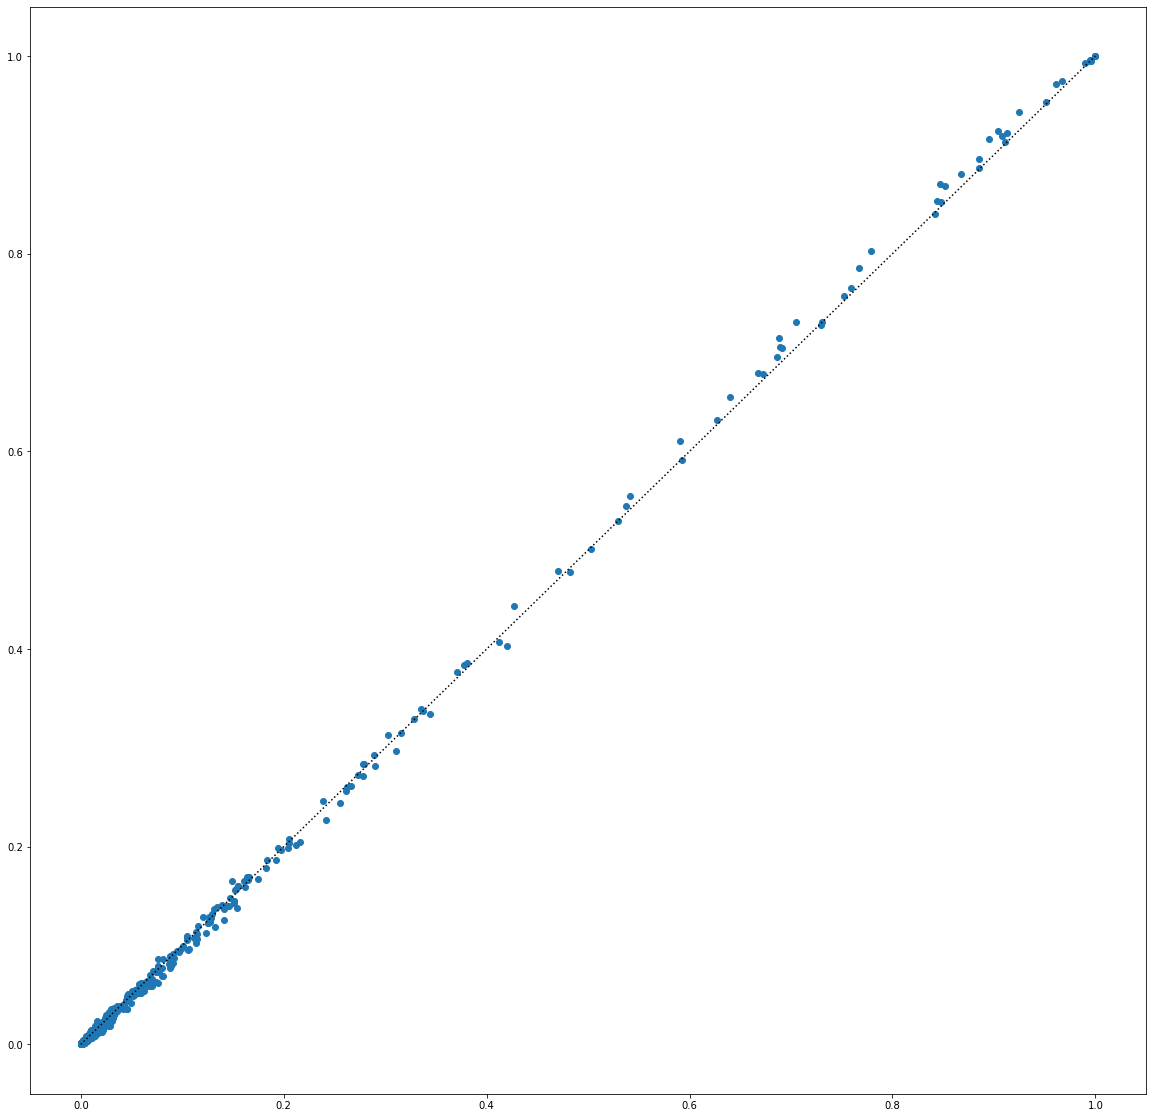

In [14]:
px=x.mean(axis=0)
pg=s.mean(axis=0)
plt.scatter(px,pg)
plt.plot([np.min(px),np.max(px)],[np.min(px),np.max(px)],c='black',linestyle=':')

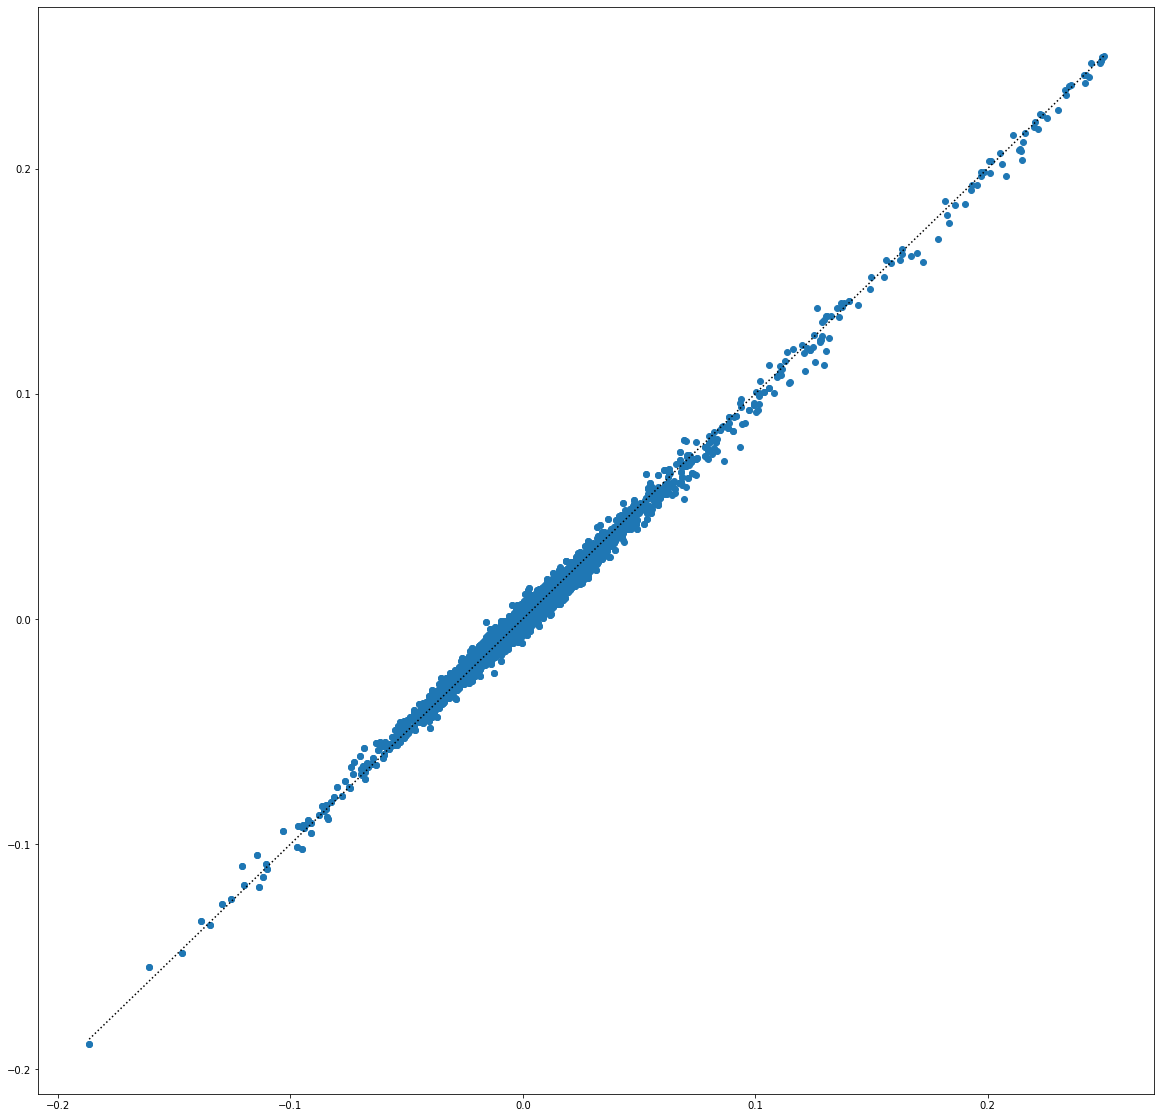

In [15]:
ppx=(np.matmul(x.T,x)/x.shape[0]-np.multiply(px[np.newaxis,:],px[:,np.newaxis])).flatten()
ppg=(np.matmul(s.T,s)/s.shape[0]-np.multiply(pg[np.newaxis,:],pg[:,np.newaxis])).flatten()
plt.scatter(ppx,ppg)
plt.plot([np.min(ppx),np.max(ppx)],[np.min(ppx),np.max(ppx)],c='black',linestyle=':')

## Performance: PCA

In [16]:
pca = PCA(n_components=2)
pca.fit(x)

PCA(n_components=2)

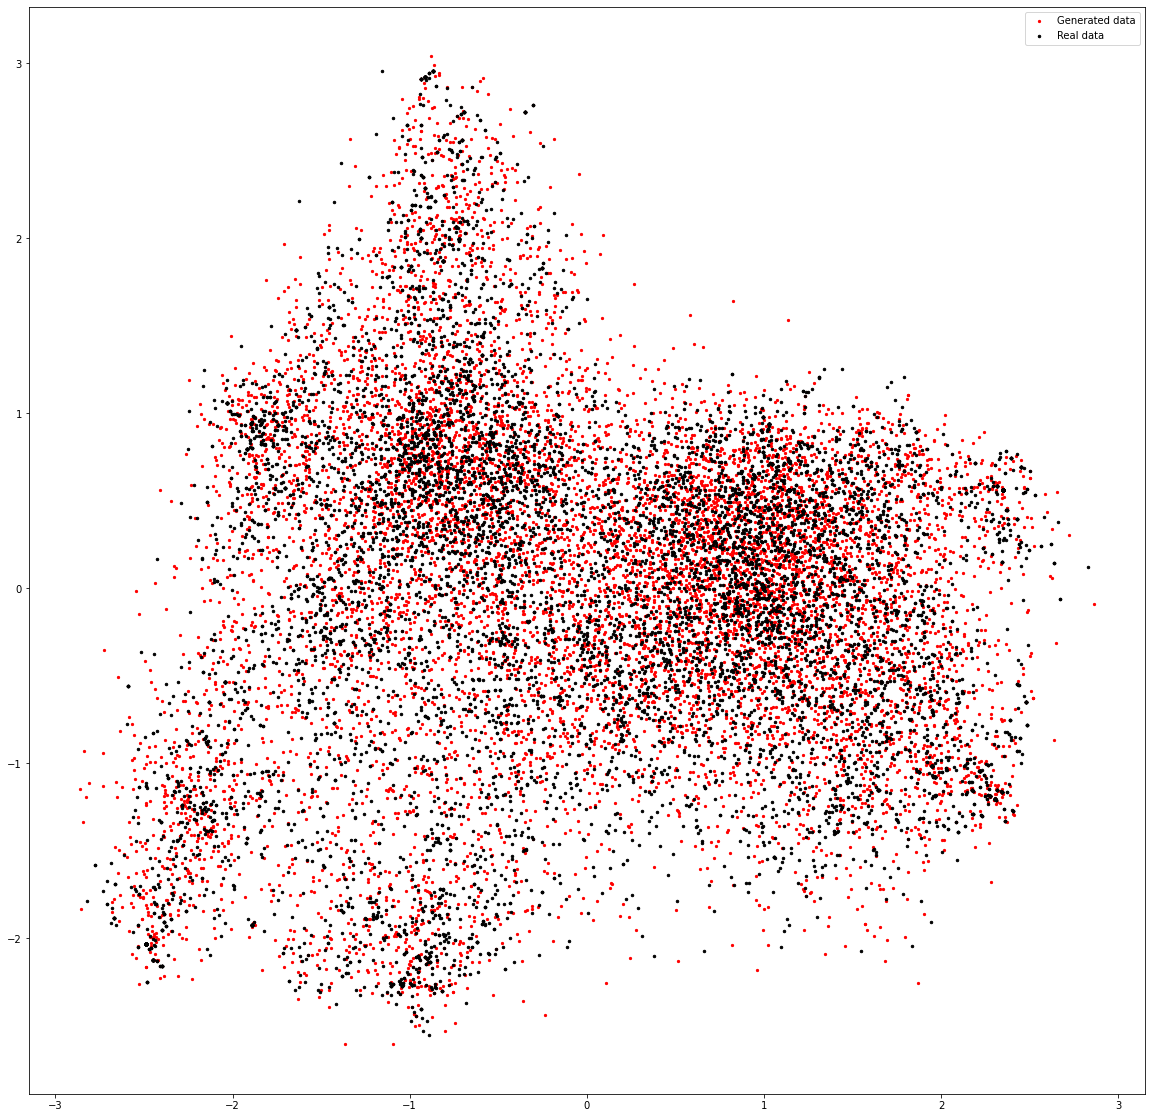

In [17]:
xpca=pca.transform(x)
gpca=pca.transform(s)
if comparetodata is not None:
    xcpca=pca.transform(xc)

plt.scatter(gpca[:,0],gpca[:,1], s=5, c='red', label='Generated data')
if comparetodata is not None:
    plt.scatter(xcpca[:,0],xcpca[:,1], c='green',label='Other method')
plt.scatter(xpca[:,0],xpca[:,1], s=6, c='black',label='Real data')
plt.legend()

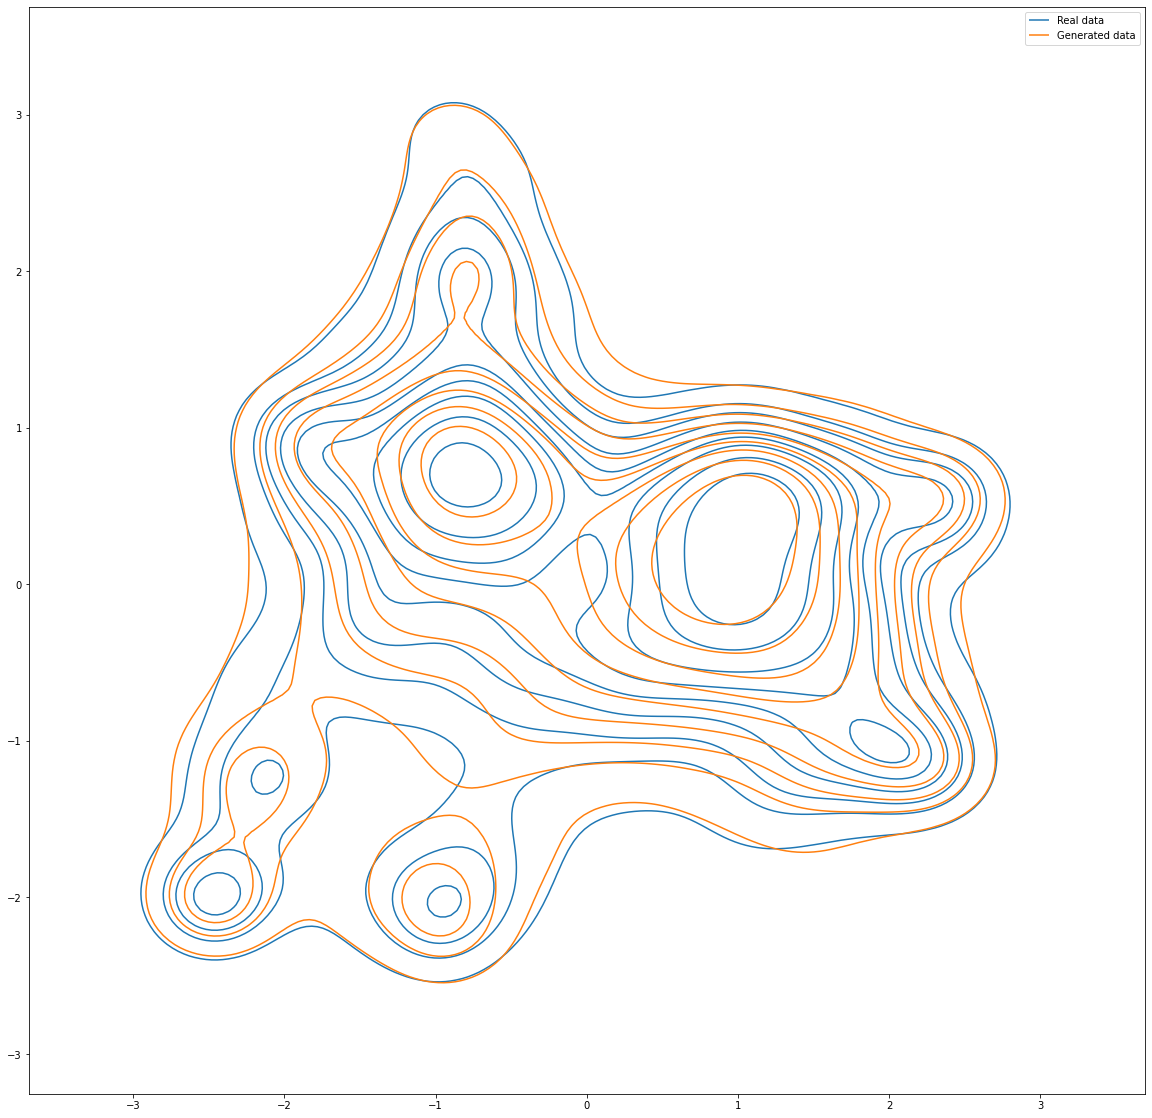

In [18]:
sns.kdeplot(x=xpca[:,0], y=xpca[:,1], levels=10, bw_adjust=1, label='Real data')
sns.kdeplot(x=gpca[:,0], y=gpca[:,1], levels=10, bw_adjust=1, label='Generated data')
plt.legend()

## Performance: UMAP

In [19]:
proj = UMAP()
proj.fit(np.vstack([x,s]))

UMAP(dens_frac=0.0, dens_lambda=0.0)

/home/szamuner/.local/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


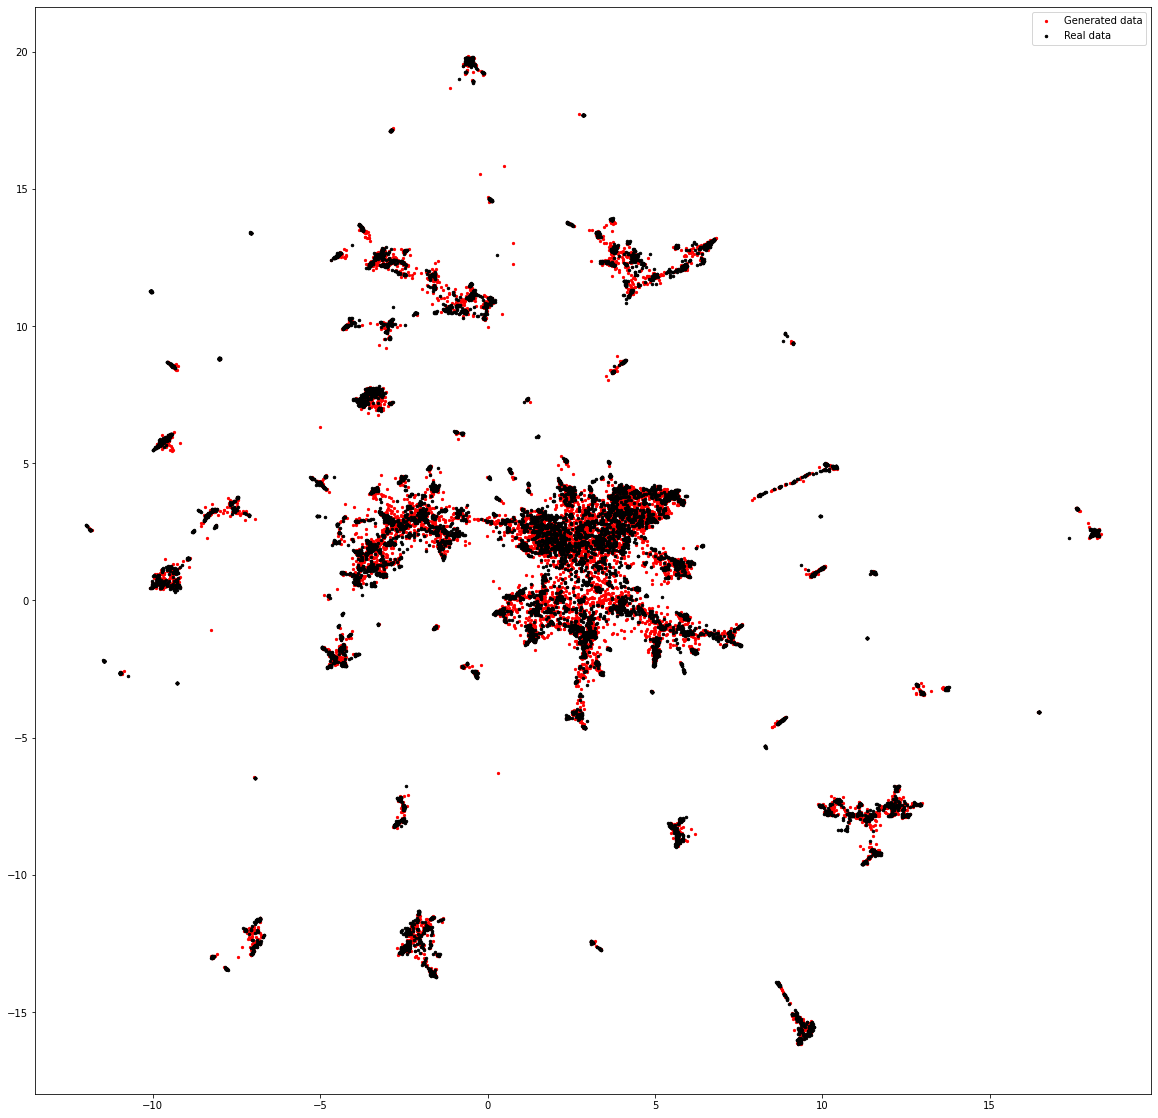

In [20]:
xumap=proj.transform(x)
gumap=proj.transform(s)
if comparetodata is not None:
    xcumap=proj.transform(xc)

plt.scatter(gumap[:,0],gumap[:,1], s=5, c='red', label='Generated data')
if comparetodata is not None:
    plt.scatter(xcumap[:,0],xcumap[:,1], c='green',label='Other method')
plt.scatter(xumap[:,0],xumap[:,1], s=6, c='black',label='Real data')
plt.legend()

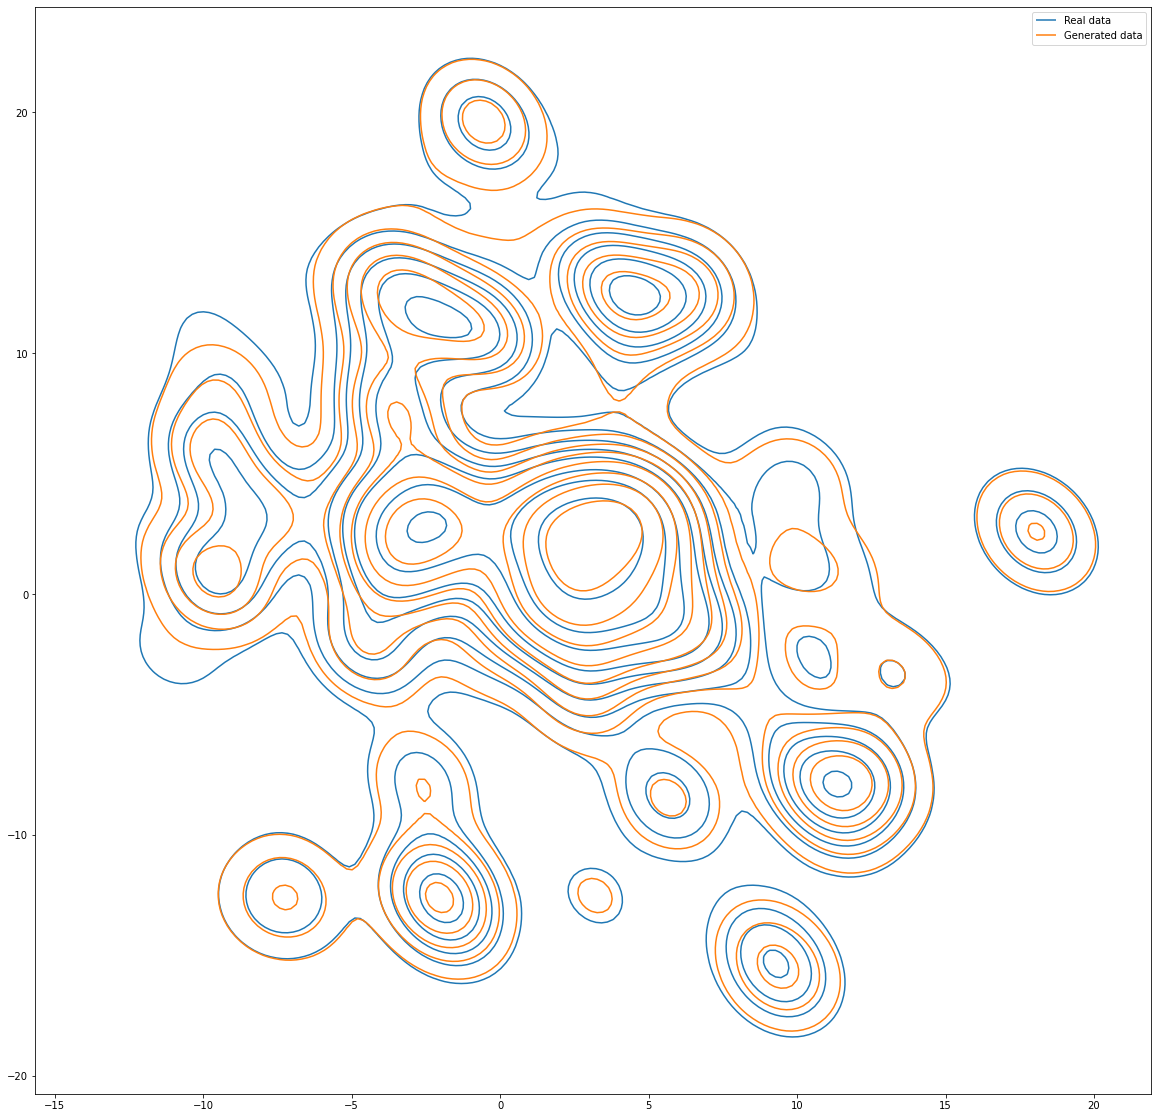

In [21]:
sns.kdeplot(x=xumap[:,0], y=xumap[:,1], levels=10, bw_adjust=1, label='Real data')
sns.kdeplot(x=gumap[:,0], y=gumap[:,1], levels=10, bw_adjust=1, label='Generated data')
plt.legend()